# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [92]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [96]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))
                                      ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))])
# Create training set and define training dataloader
## YOUR CODE HERE ##

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [94]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig = plt.figure(figsize=(25, 4))
    for i in range(5):
        ax = fig.add_subplot(1,5, i+1, xticks=[], yticks=[]) # Changed this function a bit, to have smaller pictures alongside eachother
        image = images[i].numpy()
        plt.imshow(image.T)                                                        
        ax.set_title(classes[labels[i]])

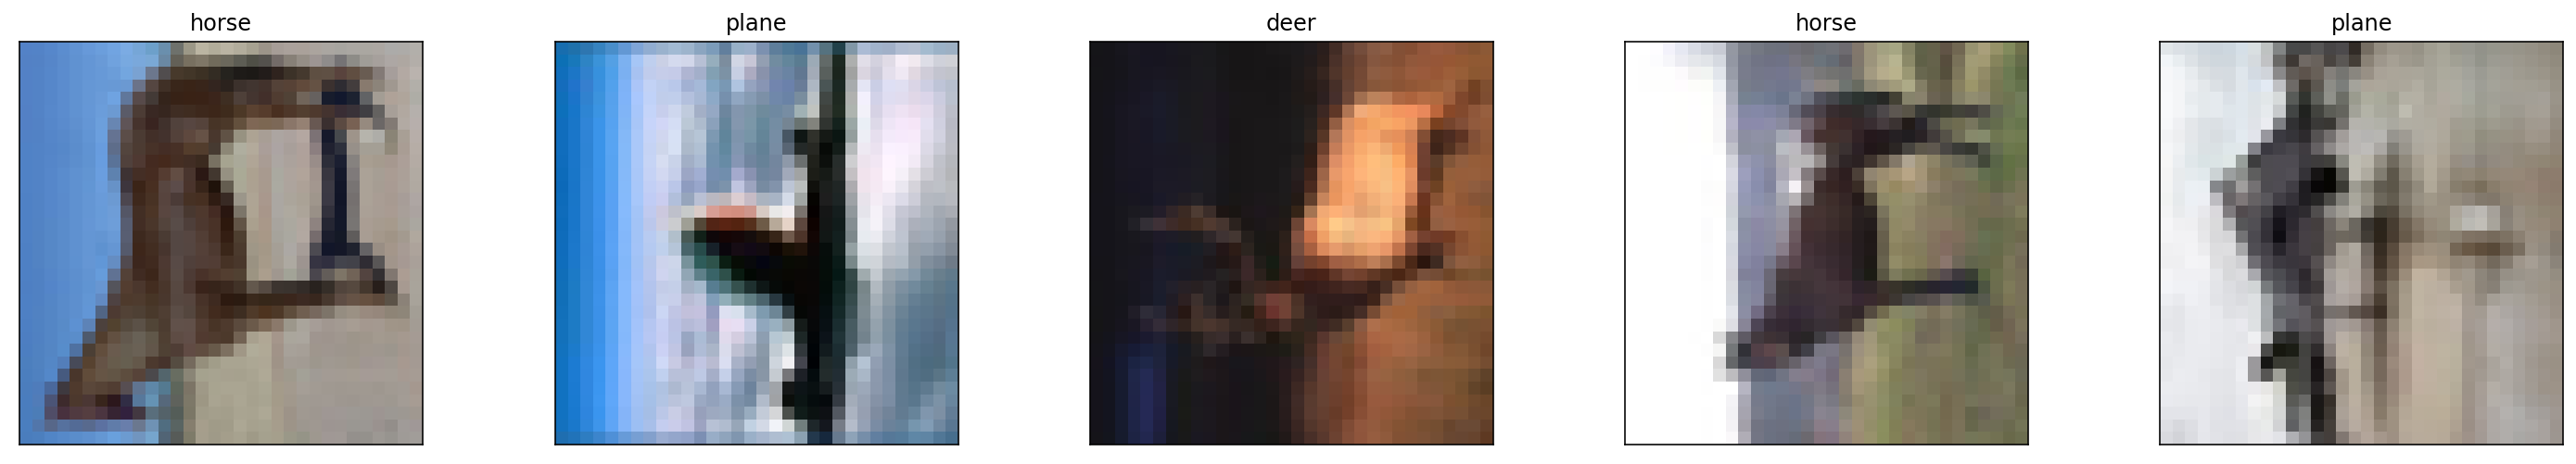

In [95]:
# Explore data
# I commented the augmentation and normalization part in the transforms to explore the pictures and then put them back
## YOUR CODE HERE ##
show5(trainloader)

In [97]:
images, labels = next(iter(trainloader))
images[0].shape

torch.Size([3, 32, 32])

In [98]:
images.size()

torch.Size([64, 3, 32, 32])

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [99]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [100]:
## YOUR CODE HERE ##
# loss function Negative Log-Likelihood Loss
criterion = nn.NLLLoss()

## optimizer Adam. Apparently it is worse than SGD https://opt-ml.org/papers/2021/paper53.pdf
#optimizer = optim.Adam(model.parameters(), lr=0.001)

##loss function Categorical Cross-Entropy
#criterion = nn.CrossEntropyLoss()

# optimizer Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [101]:
torch.cuda.is_available()

False

In [103]:
## I would like to see how well is my model before training. since we have 10 classes, I expect an accuracy of 10% ##
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logpbs = model(images)
            test_loss += criterion(logpbs, labels).item()
            pbs = torch.exp(logpbs)
            top_p, top_class = pbs.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 2.305.. Test accuracy: 0.100


In [104]:
## YOUR CODE HERE ##
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 60
step = 0
print_every = 250

train_losses = []

for e in range(epochs):
    train_loss = 0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        step +=1
        logpbs = model(images)
        loss = criterion(logpbs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if step % print_every == 0:
            print("Epoch {}/{}..".format(e+1, epochs),
                  "Training Loss: {:.3f}..".format(train_loss/step))
        
    train_losses.append(train_loss/len(trainloader))
    step = 0

Epoch 1/60.. Training Loss: 2.303..
Epoch 1/60.. Training Loss: 2.302..
Epoch 1/60.. Training Loss: 2.301..
Epoch 2/60.. Training Loss: 2.294..
Epoch 2/60.. Training Loss: 2.292..
Epoch 2/60.. Training Loss: 2.291..
Epoch 3/60.. Training Loss: 2.281..
Epoch 3/60.. Training Loss: 2.279..
Epoch 3/60.. Training Loss: 2.276..
Epoch 4/60.. Training Loss: 2.261..
Epoch 4/60.. Training Loss: 2.258..
Epoch 4/60.. Training Loss: 2.254..
Epoch 5/60.. Training Loss: 2.238..
Epoch 5/60.. Training Loss: 2.233..
Epoch 5/60.. Training Loss: 2.227..
Epoch 6/60.. Training Loss: 2.204..
Epoch 6/60.. Training Loss: 2.198..
Epoch 6/60.. Training Loss: 2.193..
Epoch 7/60.. Training Loss: 2.171..
Epoch 7/60.. Training Loss: 2.163..
Epoch 7/60.. Training Loss: 2.156..
Epoch 8/60.. Training Loss: 2.132..
Epoch 8/60.. Training Loss: 2.122..
Epoch 8/60.. Training Loss: 2.118..
Epoch 9/60.. Training Loss: 2.097..
Epoch 9/60.. Training Loss: 2.091..
Epoch 9/60.. Training Loss: 2.085..
Epoch 10/60.. Training Loss:

Plot the training loss (and validation loss/accuracy, if recorded).

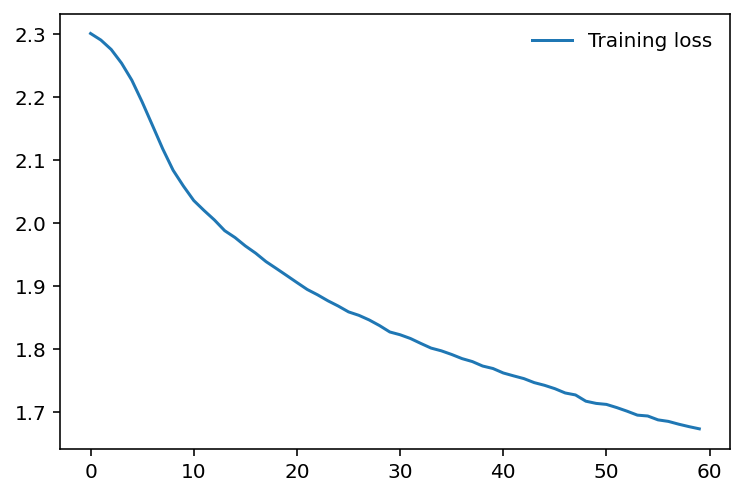

In [105]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [106]:
## YOUR CODE HERE ##
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logpbs = model(images)
            test_loss += criterion(logpbs, labels).item()
            pbs = torch.exp(logpbs)
            top_p, top_class = pbs.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 1.624.. Test accuracy: 0.431


In [111]:
model2 = torchvision.models.densenet121(pretrained=True)
model2

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [112]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 64)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(64, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model2.classifier = classifier

In [113]:
## Also here let us see how this model does without being trained
test_loss = 0
accuracy = 0
model2.eval()
with torch.no_grad():
    for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logpbs = model2(images)
            test_loss += criterion(logpbs, labels).item()
            pbs = torch.exp(logpbs)
            top_p, top_class = pbs.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 2.306.. Test accuracy: 0.100


In [116]:
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)

model2.to(device)

epochs = 30
step = 0
print_every = 250

train_losses = []

for e in range(epochs):
    train_loss = 0
    model2.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        step +=1
        logpbs = model2.forward(images)
        loss = criterion(logpbs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if step % print_every == 0:
            print("Epoch {}/{}..".format(e+1, epochs),
                  "Training Loss: {:.3f}..".format(train_loss/step))
        
    train_losses.append(train_loss/len(trainloader))
    step = 0

Epoch 1/30.. Training Loss: 1.443..
Epoch 1/30.. Training Loss: 1.440..
Epoch 1/30.. Training Loss: 1.439..
Epoch 2/30.. Training Loss: 1.423..
Epoch 2/30.. Training Loss: 1.419..
Epoch 2/30.. Training Loss: 1.418..
Epoch 3/30.. Training Loss: 1.388..
Epoch 3/30.. Training Loss: 1.388..
Epoch 3/30.. Training Loss: 1.393..
Epoch 4/30.. Training Loss: 1.388..
Epoch 4/30.. Training Loss: 1.385..
Epoch 4/30.. Training Loss: 1.385..
Epoch 5/30.. Training Loss: 1.365..
Epoch 5/30.. Training Loss: 1.365..
Epoch 5/30.. Training Loss: 1.365..
Epoch 6/30.. Training Loss: 1.355..
Epoch 6/30.. Training Loss: 1.363..
Epoch 6/30.. Training Loss: 1.362..
Epoch 7/30.. Training Loss: 1.356..
Epoch 7/30.. Training Loss: 1.350..
Epoch 7/30.. Training Loss: 1.353..
Epoch 8/30.. Training Loss: 1.342..
Epoch 8/30.. Training Loss: 1.346..
Epoch 8/30.. Training Loss: 1.344..
Epoch 9/30.. Training Loss: 1.330..
Epoch 9/30.. Training Loss: 1.327..
Epoch 9/30.. Training Loss: 1.329..
Epoch 10/30.. Training Loss:

KeyboardInterrupt: 

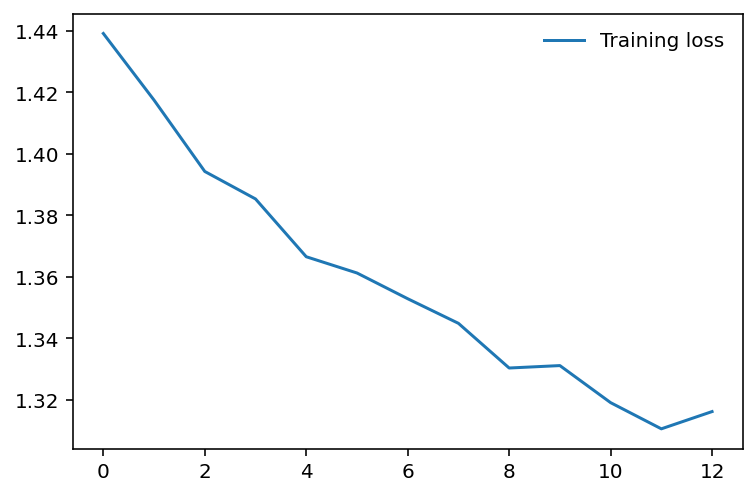

In [117]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
#plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [118]:
## YOUR CODE HERE ##
test_loss = 0
accuracy = 0
model2.eval()
with torch.no_grad():
    for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logpbs = model2(images)
            test_loss += criterion(logpbs, labels).item()
            pbs = torch.exp(logpbs)
            top_p, top_class = pbs.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 1.369.. Test accuracy: 0.532


## Saving your model
Using `torch.save`, save your model for future loading.

In [91]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'checkpoint.pth')
torch.save(model2.state_dict(), 'checkpoint2.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

